In [78]:
import numpy as np
import pyshtools as pysh
from scipy import io
from scipy import interpolate
from matplotlib import pyplot as plt
import sys
from tqdm import tqdm
from multiprocessing import Pool,cpu_count,freeze_support
import itertools 
import logging
import math
import time
import par

Si il y a une erreur sur les modules : 

    - Faire clique droit --> new console for notebook
    - taper les commandes suivantes : 
        - conda install numpy
        - conda install matplotlib
        - conda install -c conda-forge pyshtools
    -Kernel --> restart kernel
    
Si un module est ajouté : conda env export -n <env-name>
    
Quand tu quitte l'env : ne pas oublier de saµuvegarder le dépôt vers Github ! (j'ai déjà perdu des données comme ça ^^) :
    -Enregistrer le fichier ! Selectionner le fichier, clique droit, download, puis push le fichier sur git. 
    

# Code to solve the elastic sea level equation following 

Kendall et al., 2005 and Austermann et al., 2015

J. Austermann 2015

Translated to Python and modified by A. Wickert, 2015

## Functions called in the main body

Functions used in the loop

In [79]:
def shtoolsconvertor(coeff):
    '''
    A function set the spherical coefficient to the format of pyshtools (from vector to matrix)
    '''
    l=coeff.shape[0]
    maxdeg=int((-1+math.sqrt(1+8*l))/2)
    Out=np.zeros((maxdeg,maxdeg))+1j*0
    c=0
    for i in range(0,maxdeg):
        c=c+i
        for j in range(0,i+1):
            Out[i,j]=coeff[c+j]
    return Out

def iconvertor(i):
    #calculate the indices of the spherical coefficient in a vector to the indices in a matrix
    j=0
    while i/(j+1)-j/2<0 or i/(j+1)-j/2>1 :
        j+=1
    k=i-j*(j+1)/2
    if k>j:
        k=0
        j+=1
    return int(j),int(k)

def love_lm(num,grid, group='m'):
  """
  no dc shift also for gravity love number
  """
  num = num[:grid.maxdeg]
  h = np.hstack(( 0, num.squeeze() ))
  h_lm = [];
  print =(group)
  if group == 'l':
    # This is the standard for Jerry's code
    for l in range(grid.maxdeg+1):
      h_lm += ([h[l]] * (l + 1))
  elif group == 'm':
    # This works with the spherical harmonic library I am using here
    for m in range(grid.maxdeg+1):
      h_lm += (list(h[m:]))
    # Although an analagous expression to Jerry's produces a plot that is more
    # like his...
    #for m in range(maxdeg+1):
    #  h_lm += ([h[m]] * m)
  h_lm = np.array(h_lm)
  return h_lm

def get_tlm(maxdeg,earth, group='l'):
  T_lm = []
  T = np.zeros(maxdeg+1)
  const = 4*np.pi*earth.a**3/earth.M_e
  if group == 'l':
    # This is the standard for Jerry's code
    for l in range(maxdeg+1):
      T[l] = const / (2 * l + 1.)
      T_lm += ([T[l]] * (l + 1)) # IMPORTANT -- must have one entry per SH order
  elif group == 'm':
    # This works with the spherical harmonic library I am using here, I think
    for m in range(maxdeg):
      T[m] = const / (2 * m)
      T_lm += (list(T[:m+1])) # IMPORTANT
  T_lm = np.array(T_lm)
  return T_lm

def calc_rot(L_in, love, earth):
  # extract degree 2: 
  L20 = L_in[2,0]
  L21 = L_in[2,1] 
  L22 = L_in[2,2]
  k_L = love.k_el[1] # This has 256 values
  k_T = love.k_el_tide[1] # This has 256 values


  II = earth.sqrt_32_15 * np.pi * earth.a**4 * np.real(L21)-1j*earth.sqrt_32_15 * np.pi * earth.a**4 * np.imag(L21)

  # equation from Mitrovica and Wahr 2005

  m0 = II/earth.CminA * (1 + k_L) / ( 1 - (k_T/earth.k_hydro) )
  m1 = np.real(m0)
  m2 = np.imag(m0)
  m3 = 0

  m = np.hstack((m1, m2, m3))

  # calculate the perturbation to the rotational potential from Milne 1998
    
  La_out = np.zeros(L_in.shape)+1j*0

  La_out[0,0] = earth.a**2 * earth.omega**2/3 * (np.sum(m**2) + 2*m3)+1j*0
  La_out[2,0] = earth.a**2 * earth.omega**2/(6*5**.5) * (m1**2 + m2**2 - 2*m3**2 - 4*m3)+1j*0
  La_out[2,1] = earth.a**2 * earth.omega**2/30**.5 * (m1*(1+m3) - 1j*m2*(1+m3))
  La_out[2,2] = earth.a**2 * earth.omega**2/5**.5 * 24**.5 * ( (m2**2-m1**2) + 1j*2*m1*m2 )

  return La_out

def calc_rot_visc(SL, love, t_it,model_p):
  # extract degree 2: 
  L00 = SL.delL[0,0]
  L20 = SL.delL[2,0]
  L21 = SL.delL[2,1] 
    
  C = model_p.C
  I1=math.sqrt(32/15)*math.pi*model_p.a**4*np.real(L21)
  I2=math.sqrt(32/15)*math.pi*model_p.a**4*np.imag(L21)
  I3=8/3*math.pi*model_p.a**4*(L00-L20/math.sqrt(5))
  I=np.array([I1,I2,I3])
  if t_it==1 :
        V_lm=np.array([0,0,0])
        V_lm_T=np.array([0,0,0])
  else : 
    V_lm = np.dot(love.beta_konly_l[t_it-1,:t_it-2],SL.sdelI[:,:t_it-2].transpose())
    V_lm_T = np.dot(love.beta_konly_tide[t_it-1,:t_it-2],SL.sdelm[:,:t_it-2].transpose())
  temp = 1/(1-love.k_el_tide[1]/model_p.k_f)*(1/model_p.CminA * ((1+love.k_el[1])*I + V_lm) + V_lm_T/model_p.k_f)
  # calculate the perturbation to the rotational potential from Milne 1998
  m1=temp[0]
  m2=temp[1]
  temps = -1/(1-love.k_el_tide[1]/model_p.k_f)*(1/C * ((1+love.k_el[1])*I + V_lm))
  m3=temp[2]
  m=np.array([m1,m2,m3])
  SL.sdelI[:,t_it-1] = I - np.sum(SL.sdelI[:,:t_it-2],1)
  SL.sdelm[:,t_it-1] = m - np.sum(SL.sdelm[:,:t_it-2],1)
    
  SL.delLa = np.zeros(SL.delL.shape)+1j*0

  SL.delLa[0,0] = model_p.a**2 * model_p.omega**2/3 * (np.sum(m**2) + 2*m3)+1j*0
  SL.delLa[2,0] = model_p.a**2 * model_p.omega**2/(6*5**.5) * (m1**2 + m2**2 - 2*m3**2 - 4*m3)+1j*0
  SL.delLa[2,1] = model_p.a**2 * model_p.omega**2/30**.5 * (m1*(1+m3) - 1j*m2*(1+m3))
  SL.delLa[2,2] = model_p.a**2 * model_p.omega**2/5**.5 * 24**.5 * ( (m2**2-m1**2) + 1j*2*m1*m2 )

def calc_beta(self,grid) :
    maxdeg=grid.maxdeg
    self.beta_l = [np.zeros((maxdeg,maxdeg+1)) for i in range(len(grid.time_step)-1)]
    self.beta_konly_l = [np.zeros((maxdeg+1,)) for i in range(len(grid.time_step)-1)]
    for t_it in tqdm(range(1,len(grid.time_step)),"BETA"):        
        for n in range(1,t_it-1):
            beta = np.zeros((maxdeg,))
            for lm in range(maxdeg):
                num_mod = self.mode_found[lm][0]
                beta[lm] = np.sum((self.k_amp[lm,:num_mod] - self.h_amp[lm,:num_mod])/self.spoles[lm,:num_mod] * (1 - np.exp(- self.spoles[lm,:num_mod]* (-grid.time_step[t_it] + grid.time_step[n]))))
            self.beta_l[t_it-1][n-1,:] = np.zeros((beta.shape[0]+1,)) # add 0 LN
            self.beta_l[t_it-1][n-1,1:]=beta
            # for rotation only needed for degree 2
            lm = 1
            num_mod = self.mode_found[lm][0]
            self.beta_konly_l[t_it-1][n-1] = np.sum((self.k_amp[lm,:num_mod])/self.spoles[lm,:num_mod] * (1 - np.exp(- self.spoles[lm,:num_mod] * (-grid.time_step[t_it] + grid.time_step[n]))));

def calc_beta_tide(self,grid):
    maxdeg=grid.maxdeg
    self.beta_tide = [np.zeros((maxdeg,maxdeg+1)) for i in range(len(grid.time_step)-1)]
    self.beta_konly_tide = [np.zeros((maxdeg+1,)) for i in range(len(grid.time_step)-1)]
    for t_it in tqdm(range(1,len(grid.time_step)),"BETA_TIDE"):
        for n in range(1,t_it-1):
            beta = np.zeros((maxdeg,))
            for lm in range(0,maxdeg):
                num_mod = self.mode_found[lm][0];
                beta[lm]= sum((self.k_amp_tide[lm,:num_mod] - self.h_amp_tide[lm,:num_mod])/self.spoles[lm,:num_mod]* (1 - np.exp(- self.spoles[lm,:num_mod] * (-grid.time_step[t_it] + grid.time_step[n]))));
            self.beta_tide[t_it-1][n-1,:] = np.zeros((beta.shape[0]+1,)) # add 0 LN
            self.beta_tide[t_it-1][n-1,1:]=beta

            # for rotation only needed for degree 2
            lm = 1
            num_mod = self.mode_found[lm][0]
            self.beta_konly_tide[t_it-1][n-1] = np.sum((self.k_amp_tide[lm,:num_mod])/self.spoles[lm,:num_mod] * (1 - np.exp(- self.spoles[lm,:num_mod] * (-grid.time_step[t_it] + grid.time_step[n]))));

def calc_beta_counter(self):
    self.beta_counter = np.ones(self.h.shape);
    l_it = 1;
    for lm_it in range(len(self.h)-1):
        if lm_it == l_it*(l_it+1)/2:
            self.beta_counter[lm_it+1] = self.beta_counter[lm_it]+1;
            l_it = l_it+1;
        else:
            self.beta_counter[lm_it+1] = self.beta_counter[lm_it];
            
def to_vector(coeff):
        l=coeff.shape[0]
        vect=np.zeros((int((l*(l+1))/2),))
        c=0
        for i in range(l):
            for j in range(i):
                vect[c]=coeff[i,j]
                c+=1
        return vect
    
def to_grd(coeff):
    flm=np.array([np.real(coeff),np.imag(coeff)])
    Clm=pysh.shio.SHctor(flm)
    return np.real(pysh.SHCoeffs.from_array(Clm).expand(grid='GLQ', lat=None, colat=None, lon=None, degrees=True, zeros=None, lmax=None, lmax_calc=None, extend=True, backend=None, nthreads=0).to_array())
       

Definition of the class used in the loop

In [145]:
############
#CLASS SPHERIC
############       

class sphericalobject(object):
    '''
    A class defining the spherical object and it's method 
    method to convert the grid to spherical coefficient and spherical coefficient to grid
    '''
    def __init__(self,grd,t='grd'):
        if t=='grd' :
            self.grd=grd
            self.isgrd=True
            self.iscoeff=False
        elif t=='coeff':
            self.coeff=grd
            self.isgrd=False
            self.iscoeff=True
        self.saved=np.array([])
        
    def grdtocoeff(self):
        if self.isgrd:
            CSlm=pysh.SHGrid.from_array(self.grd,'GLQ').expand(normalization='4pi', csphase=1, lmax_calc=None, backend=None, nthreads=0).to_array()
            flm=pysh.shio.SHrtoc(CSlm)
            self.iscoeff=True
            self.coeff=flm[0,:,:]+1j*flm[1,:,:]
        else :
            logging.error('error: ', "No map created for this spherical object. Check if you have created the object with map or haven't run the coefftogrd() method")
            sys.exit(1)
        return self
        
    def coefftogrd(self):
        if self.iscoeff :
            flm=np.array([np.real(self.coeff),np.imag(self.coeff)])
            Clm=pysh.shio.SHctor(flm)
            self.grd=np.real(pysh.SHCoeffs.from_array(Clm).expand(grid='GLQ', lat=None, colat=None, lon=None, degrees=True, zeros=None, lmax=None, lmax_calc=None, extend=True, backend=None, nthreads=0).to_array())
        else :
            logging.error('error: ', "No coeff created for this spherical object. Check if you have created the object with coeff or haven't run the grdtocoeff() method")
            sys.exit(1)
        return self
    
    def multiply(self,flm2):
        flm1=np.array([np.real(self.coeff),np.imag(self.coeff)])
        Clm1=pysh.shio.SHctor(flm1)
        flm2=np.array([np.real(flm2),np.imag(flm2)])
        Clm2=pysh.shio.SHctor(flm2)
        grd1=pysh.SHCoeffs.from_array(Clm1).expand(grid='GLQ', lat=None, colat=None, lon=None, degrees=True, zeros=None, lmax=None, lmax_calc=None, extend=True, backend=None, nthreads=0).to_array()
        grd2=pysh.SHCoeffs.from_array(Clm2).expand(grid='GLQ', lat=None, colat=None, lon=None, degrees=True, zeros=None, lmax=None, lmax_calc=None, extend=True, backend=None, nthreads=0).to_array()                                         
        grd=grd1*grd2
        Clm=pysh.SHGrid.from_array(grd,'GLQ').expand(normalization='4pi', csphase=1, lmax_calc=None, backend=None, nthreads=0).to_array()
        flm= pysh.shio.SHrtoc(Clm)
        return flm[0,:,:]+1j*flm[1,:,:]
    
    def save_prev(self):
        if self.iscoeff : 
            self.prev=self.coeff.copy()
        return self
    
    def save(self):        
        if self.iscoeff : 
            if self.saved.shape[0]==0:
                self.saved=np.array([self.coeff])
            else :
                self.saved=np.concatenate((self.saved,np.array([self.coeff.copy()])),axis=0)
        else :
            logging.error('error: ', "No coeff created for this spherical object. Check if you have created the object with coeff or haven't run the grdtocoeff() method")
            sys.exit(1)
        return self
    
    def modify(self,gc,t='grd'):
        if t=='grd':
            self.grd=gc
            self.iscoeff=False
            self.isgrd=True
        elif t=='coeff':
            self.coeff=gc
            self.isgrd=False
            self.iscoeff=True
        return self
    
                
    
#########
#CLASS OCEAN
#########

class spherical_ocean_function(sphericalobject):
    def __init__(self) :
        self.isgrd=False
        self.iscoeff=False
        self.saved=np.array([])
        self.rho=1000.
        
    def update_oc_0(self):
        # on utilise les deux type d'entrées. Il faut donc créer les deux types de données
        self.oc_0_grd=self.grd
        self.oc_0_coeff=self.coeff 
        
    def evaluate_ocean(self,topo) :
        out = -0.5*np.sign(topo)+0.5
        out = 0.5*np.sign(out-0.6)+0.5
        self.grd=out
        self.isgrd=True
        return self

###########
#CLASS SED
###########
    
class spherical_sed(sphericalobject):
    def __init__(self) : 
        self.isgrd=False
        self.iscoeff=False
        self.saved=np.array([])
        self.rho = 2300.
    
    def load(self,grid):
        self.sed=np.zeros((len(grid.time_step),grid.nlats,grid.nlons))
        self.isgrd=True
        return self
        
    def calc_del_sed(self,t_it) :# avec ça deli seras près définit et prev doit être calculer
        self.grd=self.sed[t_it,:,:]-self.sed[0,:,:]
        self.isgrd=True
        return self
    
############
#CLASS ICE
############

class spherical_ice(sphericalobject):
    def __init__(self) : 
        self.isgrd=False
        self.iscoeff=False
        self.saved=np.array([])
        self.rho=916.7
        
    def load(self,grid):
        #def the ice over tie and space ! save the ice sheet in a main parameter and then call it inside the class and not outside ! 
        data=io.loadmat('ice6g_data')# pareil à adapteer en fonction du modèle chargé !
        ice_in=data['ice6g']
        grid.time_step=data['ice_time']
        grid.time_step=grid.time_step[0]
        ice_time=grid.time_step.copy()
        self.ice=np.zeros((len(grid.time_step),grid.nlats,grid.nlons)) #adapt the name to the file data to use 
        self.ice_corrected=self.ice
        ice_lat=np.zeros((data['ice_lat'].shape[0]+3,1))
        ice_long=np.zeros((data['ice_long'].shape[0]+3,1))
        ice_lat[0],ice_lat[-1],ice_lat[1:-2] =90,-90,data['ice_lat']
        ice_long[0],ice_long[-1],ice_long[1:-2] =-0.5,-360.5,data['ice_long']
        ice_extended=np.zeros((ice_in.shape[1]+3,ice_in.shape[2]))
        ice_extended_2=np.zeros((ice_in.shape[1]+3,ice_in.shape[2]+3))
        for t_it in tqdm(range(len(grid.time_step)-1),"ICE"):
            ice_extended[0,:]= np.zeros((1,len(ice_long)-3))
            ice_extended[1:-2,:]=ice_in[t_it]
            ice_extended[-1,:]=ice_in[t_it,0,-1]*np.ones((1,len(ice_long)-3))
    
            ice_extended_2[:,0]=ice_extended[:,-1]
            ice_extended_2[:,1:-2]=ice_extended
            ice_extended_2[:,-1] = ice_extended[:,0]

            ice_interp = grid.interp_on(ice_extended_2,ice_long,ice_lat)
            
            time.sleep(0.01)
            self.ice[len(grid.time_step)-t_it-1,:,:] = ice_interp
            grid.time_step[t_it] = ice_time[len(ice_time)-t_it-1]
        
    def quick_load(self,grid):
        #def the ice over tie and space ! save the ice sheet in a main parameter and then call it inside the class and not outside ! 
        data=io.loadmat('ice6g_data')# pareil à adapteer en fonction du modèle chargé !
        ice_in=data['ice6g']
        grid.time_step=data['ice_time']
        grid.time_step=grid.time_step[0]
        ice_time=grid.time_step.copy()
        self.ice=np.zeros((len(grid.time_step),grid.nlats,grid.nlons)) #adapt the name to the file data to use 
        self.ice_corrected=self.ice
        ice_lat=np.zeros((data['ice_lat'].shape[0]+3,1))
        ice_long=np.zeros((data['ice_long'].shape[0]+3,1))
        ice_lat[0],ice_lat[-1],ice_lat[1:-2] =90,-90,data['ice_lat']
        ice_long[0],ice_long[-1],ice_long[1:-2] =-0.5,-360.5,data['ice_long']
        ice_extended=np.zeros((ice_in.shape[1]+3,ice_in.shape[2]))
        ice_extended_2=np.zeros((ice_in.shape[1]+3,ice_in.shape[2]+3))
        workers = int(cpu_count()/2)
        pool = Pool(workers)
        pbar = tqdm(total=len(ice_time),desc="ICE")
        #results=pool.starmap(par.f_print,zip(itertools.repeat(ice_time),range(len(ice_time)),ice_in))
        results=pool.starmap(par.f_ice_quick_load,zip(itertools.repeat(ice_time),itertools.repeat(ice_extended),itertools.repeat(ice_extended_2),ice_in,range(len(ice_time)),itertools.repeat(ice_long),itertools.repeat(ice_lat),itertools.repeat(grid.lats),itertools.repeat(grid.elons)))
        self.ice=np.array([results[i][0] for i in range(len(results))])
        grid.time_step=np.array([results[i][1] for i in range(len(results))])
        pbar.update(len(ice_time))
        
    def calc_del_ice(self,t_it) :# avec ça deli seras près définit et prev doit être calculer
        self.grd=self.ice[t_it,:,:]-self.ice[0,:,:]
        self.isgrd=True
        
#################
#CLASS TOPO
#################
        
class spherical_topo(sphericalobject):
    def __init__(self) : 
        self.isgrd=False
        self.iscoeff=False
        self.saved=np.array([])
        
    def load(self,grid,ice,sed):
        #def the ice over tie and space ! save the ice sheet in a main parameter and then call it inside the class and not outside ! 
        data=io.loadmat('topo_SL')
        self.topo_pres=grid.interp_on(data['topo_bed'],np.transpose(data['lon_topo'][0]),np.transpose(data['lat_topo'][0]))+ice.ice[-1,:,:] # à adapter pour l'entrée des données !
        self.topo_initial = self.topo_pres - ice.ice[-1,:,:] - sed.sed[-1,:,:] + ice.ice[0,:,:] + sed.sed[0,:,:]
        self.topo=np.zeros((len(grid.time_step),self.topo_initial.shape[0],self.topo_initial.shape[1]))
        for t_it in tqdm(range(1,len(grid.time_step)),"TOPO"):
            self.topo[t_it,:,:]=self.topo_pres - ice.ice[-1,:,:] - sed.sed[-1,:,:] + ice.ice[0,:,:] + sed.sed[0,:,:];
            time.sleep(0.001)
        self.topo[0,:,:]=self.topo_pres
        self.grd=self.topo[0,:,:]
        return self
    
    def update_topo_0(self):
        self.topo_0=self.topo[0,:,:]
        return self
    
    def ice_correction(self,ice,grid,oc):
        for t_it in range(len(grid.time_step)-1): # paralélisable !!!!
            self.topo[t_it,:,:]=self.topo[t_it,:,:]-ice.ice_corrected[t_it,:,:]+ice.ice[t_it,:,:]
            check1 = spherical_ocean_function().evaluate_ocean(-self.grd+ice.ice[t_it,:,:])
            check2 = spherical_ocean_function().evaluate_ocean(self.grd-ice.ice[t_it,:,:])
            check3 = spherical_ocean_function().evaluate_ocean(-ice.ice[t_it,:,:]*ice.rho-self.grd+ice.ice[t_it,:,:]*oc.rho)
            check2 = check2.grd*check3.grd
            ice.ice_corrected[t_it,:,:] = check1.grd*ice.ice[t_it,:,:]+check2*ice.ice[t_it,:,:]
            self.topo[t_it,:,:]=self.topo[t_it,:,:]+ice.ice_corrected[t_it,:,:]-ice.ice[t_it,:,:]
            
            
############
#CLASS SEA LEVEL
############

class spherical_sea_level(object):
    
    def __init__(self,grid):
        self.delL=0 #: coeff
        self.delL_prev=0
        self.TO=sphericalobject(np.zeros((grid.maxdeg+1,grid.maxdeg+1))) #: coeff mais créer avec des grids
        self.sdelS=0 #: coeff
        self.delS=0 #: coeff
        self.sdelL=np.zeros((len(grid.time_step),grid.maxdeg+1,grid.maxdeg+1))+1j*0 #: coeff
        self.delLa=np.zeros((len(grid.time_step),grid.maxdeg+1,grid.maxdeg+1))+1j*0 #: coeff
        self.delLa_prev=0
        self.sdelLa=np.zeros((len(grid.time_step),grid.maxdeg+1,grid.maxdeg+1))+1j*0#: coeff
        self.delSLcurl_fl=0 #: coeff
        self.delSLcurl=sphericalobject(np.zeros((grid.maxdeg+1,grid.maxdeg+1)))#: coeff
        self.RO=0 #: coeff 
        self.sdelS_new=0
        self.delSL=sphericalobject(np.zeros((grid.maxdeg+1,grid.maxdeg+1)))
        self.saved=np.array([])
        
    def save(self):
        if self.saved.shape[0]==0:
            self.saved=np.array([self.delS])
        else :
            self.saved=np.concatenate((self.saved,np.array([self.delS.copy()])),axis=0)
        return self
    
############
#CLASS GRID
############

class GRID(object):
        """
        A class defining several Earth parameters
        """
        def __init__(self,model_p):
            """
            Creating the grid over wich the model_p is generated
            """
            self.model_p=model_p
            self.maxdeg=model_p.maxdeg
            self.nlons = (self.maxdeg + 1) * 2
            self.nlats = (self.maxdeg + 1)
            intgrid=pysh.SHGrid.from_zeros(self.maxdeg, grid='GLQ', kind='real', sampling=2)
            self.lats=intgrid.lats()
            self.elons  =  intgrid.lons()
            self.colats = 90 - self.lats
        
        def add_time(time_step):
            self.time_step=time_step # à ajouter dans ice grid definition
            
        def interp_on(self,grd,lon,lat):
            if grd.shape!=lon.shape :
                lon,lat=np.meshgrid(lon,lat)
            elons,lats=np.meshgrid(self.elons,self.lats)
            grd = interpolate.griddata((lon.flatten(),lat.flatten()),grd.flatten(),(elons.flatten(),lats.flatten()),method='nearest')
            grd=np.reshape(grd,(grid.lats.shape[0],grid.elons.shape[0]))
            return grd
            
        def create_ICE(self):
            return spherical_ice()
        
        def create_SED(self):
            return spherical_sed()
        
        def create_TOPO(self):
            return spherical_topo()
        
        def create_LOVE(self,way):
            return LOVE(self,way)
        
        def create_SL(self):
            return spherical_sea_level(grid)
        
            
class LOVE(object):
            """
            A class defining the love numbers used in the loops
            """
            def __init__(self,grid,way):
                love = io.loadmat('prem.l90.VM2_512')
                self.mode_found=love['mode_found']
                self.k_amp=love['k_amp']
                self.h_amp=love['h_amp']
                self.k_amp_tide=love['k_amp_tide']
                self.h_amp_tide=love['h_amp_tide']
                self.spoles=love['spoles']     
                self.k_el=love['k_el']
                self.k_el_tide=love['k_el_tide']
                self.h = love_lm(love['h_el'],grid)
                self.k = love_lm(love['k_el'],grid)
                self.h_tide = love_lm(love['h_el_tide'],grid)
                self.k_tide = love_lm(love['k_el_tide'],grid)
                self.E = 1 + self.k - self.h
                self.T = get_tlm(grid.maxdeg,grid.model_p)
                #self.T_ml = reorder_l_to_m_primary(self.T_lm)
                self.E_T = 1 + self.k_tide - self.h_tide
                
                # calculate betas
                calc_beta(self,grid)
                
                # calculate tidal betas
                calc_beta_tide(self,grid)
                
                self.beta_l=np.array(self.beta_l)
                self.beta_konly_l=np.array(self.beta_konly_l)
                self.beta_tide=np.array(self.beta_tide)
                self.beta_konly_tide=np.array(self.beta_konly_tide)
                
                # initiate mapping from l to lm
                calc_beta_counter(self)
                
  
                
            def pyspharm2shtools(self):
                self.h = sphericalobject(shtoolsconvertor(self.h),'coeff')
                self.k = sphericalobject(shtoolsconvertor(self.k),'coeff')
                self.h_tide = sphericalobject(shtoolsconvertor(self.h_tide),'coeff')
                self.k_tide = sphericalobject(shtoolsconvertor(self.k_tide),'coeff')
                self.E = sphericalobject(shtoolsconvertor(self.E),'coeff')
                self.T = sphericalobject(shtoolsconvertor(self.T),'coeff')
                #self.T_ml = shtoolsconvertor(self.T_ml)
                self.E_T = sphericalobject(shtoolsconvertor(self.E_T),'coeff')
                
#########
#CLASS EARTH
#########
                
class World_Model_Parameter(object):
    """
    A class defining several Earth parameters
    """
    
    def __init__(self):
        """
        initialize the model_p parameters
        """
        
        self.g = 9.80616
        self.maxdeg=63
        self.M_e = 5.9742*10**24 # Earth mass [kg]
        # for calc_rot
        self.omega = 7.292*10**(-5) # Earth's angular velocity
        self.k_hydro = 0.934 # degree-2 hydrostatic Love number
        self.G=6.67408*10**(-11)
        self.k_f=0.942
        self.a = 6371000 # earth radius
        self.CminA = (self.k_f*self.a**5*self.omega**2)/(3*self.G) # a, c = smallest and largest principal moments of the inertia tensor
        self.C=8.034*10**37
        self.sqrt_32_15 = (32/15.)**0.5
        self.k_max = 100
        self.epsilon = 10**-3
        self.topo_it_max = 10
    
    def create_GRID(self):
        return GRID(self)

## Parameters & Inputs

### Specify the earth parameters

setup up spherical harmonic instance, set lats/lons of grid

See Mitrovica et al. (2005) and Milne and Mitrovica (1998)

## Solve sea level equation

(after Kendall 2005, Dalca 2013 & Austermann et al. 2015)

### Loop criterion

Initialize the spherical object

calculate change in sediments and decompose into spherical harmonics both sediment and ocean function

Sea level : 
Liste des variables et de leur type dans leur utilisation : 

delL : coeff
TO : coeff mais créer avec des grids
sdelS : coeff
delS : coeff
sdelL : coeff
delLa : coeff
sdelLa : coeff
delSLcurl_fl : coeff
delSLcurl : coeff
RO : coeff 

delSL : grd mais créer avec des coeff
sdelS_new : coeff mais créer avec des grid

Conclusions : à part delSL, TO et sdelS_new, il n'y a pas besoin de définir les objets sphériques harmoniques pour le reste! On peut donc créer une class qui contient les objest sphériques harmoniques : delSL, sdelS_new et TO ainsi que les les coefficients sous forme de array : delL, TO, sdelS, delS, delLa .... etc ! 
 

### Main loop

In [146]:
def SL_conv_loop(model_p,ice,sed,topo,love,oc,SL,t_it,k): 
      '''
      Function solving the sea level equation.
      '''
      if k == 0 and topo_it==0:
        #print('oc',oc.coeff.shape,'TO',SL.TO.coeff.shape,'TO_prev',SL.TO.prev.shape,'ICE',ice.coeff.shape,'SED',sed.coeff.shape)
        SL.sdelS=oc.coeff/oc.coeff[0,0]*(-ice.rho/oc.rho*ice.coeff[0,0] + SL.TO.coeff[0,0]-SL.TO.prev[0,0])-SL.TO.coeff-SL.TO.prev
      SL.delS=SL.delS_prev + SL.sdelS
      SL.delL=ice.rho*ice.coeff + oc.rho*SL.delS+ sed.rho*sed.coeff
      SL.sdelL[t_it]=SL.delL-SL.delL_prev
      # calculate viscous contribution
      # beta contains the viscous love numbers for time t_it,
      # row index goes over the time increments, column
      # index goes over lm
      SL.V_lm = np.zeros((int((grid.maxdeg+1)*(grid.maxdeg+2)/2),))+1j*0
      SL.V_lm_T = np.zeros((int((grid.maxdeg+1)*(grid.maxdeg+2)/2),))+1j*0
      if t_it == 1:
        SL.V_lm = np.zeros((int((grid.maxdeg+1)*(grid.maxdeg+2)/2),))+1j*0
      else :
        for lm_it in range(int((grid.maxdeg+1)*(grid.maxdeg+2)/2)):
            j,k=iconvertor(lm_it)
            SL.V_lm[lm_it] = np.dot(love.beta_l[t_it-1,:t_it-2,int(love.beta_counter[lm_it]-1)].transpose(), SL.sdelL[:t_it-2,j,k])# regarder comment gérer cet partie !!!            
      calc_rot_visc(SL,love,t_it,model_p);
      SL.sdelLa[t_it-1,:,:]=SL.delLa - SL.delLa_prev
      if t_it == 1 :
        SL.V_lm_T = np.zeros((int((grid.maxdeg+1)*(grid.maxdeg+2)/2),))+1j*0
      else :
        for lm_it  in range(6) : # don't need to loop over all degrees
            j,k=iconvertor(lm_it)
            SL.V_lm_T[lm_it] = np.dot(love.beta_tide[t_it-1,:t_it-2,int(love.beta_counter[lm_it]-1)].transpose(), SL.sdelLa[:t_it-2,j,k]); # pareil réfléchir à comment gérer cette indexation
      SL.V_lm=shtoolsconvertor(SL.V_lm)  
      SL.V_lm_T=shtoolsconvertor(SL.V_lm_T)  
      # calculate sea level perturbation
      # add ice and sea level and multiply with love numbers
    
      SL.delSLcurl_fl=love.E.coeff * love.T.coeff *SL.delL+love.T.coeff*SL.V_lm+1/model_p.g*love.E_T.coeff*SL.delLa+1/model_p.g*SL.V_lm_T
      SL.delSLcurl.modify(SL.delSLcurl_fl - ice.coeff -sed.coeff,'coeff')
      SL.RO=SL.delSLcurl.multiply(oc.coeff)
      SL.delPhi_g = np.real(1/oc.coeff[0,0] * (- ice.rho/oc.rho*ice.coeff[0,0] - SL.RO[0,0] + SL.TO.coeff[0,0]))
      
      SL.sdelS_new=SL.RO + SL.delPhi_g*oc.coeff -  SL.TO.coeff - SL.delS_prev
      chi = np.abs( (np.sum(np.abs(SL.sdelS_new)) - np.sum(np.abs(SL.delS))) / np.sum(np.abs(SL.delS)))
      SL.sdelS=SL.sdelS_new.copy()
      return chi

In [147]:
def time_loop(model_p,ice,sed,topo,love,oc,SL,t_it):# sdeli peut être redéfinit aussi pour simplifier les calcules ! 
        # initial topo with the ice correction : 
        topo.modify(topo.topo[t_it,:,:])
        # grd correspond donc au topo_j défini dans le code de kendal et al.
        oc.evaluate_ocean(topo.grd).grdtocoeff()
        SL.TO.modify(topo.topo_0*(oc.grd-oc.oc_0_grd)).grdtocoeff()
        sed.calc_del_sed(t_it)
        ice.modify(ice.ice_corrected[t_it,:,:] - ice.ice_corrected[0,:,:]).grdtocoeff() # Probablement ice corrected seras enregistré !!! réfléchir à la mémoire utilisée ! 
        
        
        ice.sdeli_00=ice.coeff[0,0]-ice.deli_00_prev # peut être à passer dans l'initialisation ou le modify de ice object après leurs création
        
        
        #apply the loop solving the see level equation
        
        k = 0
        chi = model_p.epsilon * 2
        start_time = time.time()
        while (k < model_p.k_max) and (chi >= model_p.epsilon):
            chi=SL_conv_loop(model_p,ice,sed,topo,love,oc,SL,t_it,k) # oui il faut passer dans un objet sdeli_00 pour qu'il soit globale et non locale
            k+=1
        #update the prev variable for the next loop
        oc.save()
        
        SL.delS_prev=SL.delS
        SL.TO.save_prev()
        SL.delL_prev=SL.delL
        SL.delLa_prev=SL.delLa # regrouper toutes les mise a jours prev ensembles.
        ice.deli_00_prev=ice.coeff[0,0]
        oc.save_prev()

        #SL.ESL[t_it]=ice.deli_00_prev/oc.area*ice.rho/oc.rho
        SL.delSL.modify(SL.delSLcurl.coefftogrd().grd+SL.delPhi_g)
        topo.topo[t_it,:,:]=-SL.delSL.grd+topo.topo_0#update cette ligne avec le nouvel objet spherical_top

In [148]:
def topo_loop(model_p,grid,ice,sed,topo,love,oc,SL,topo_it):
     #regarder si il n'y a pas une boucle while plutot avec un critère de convergence pour stopper la boucle.
        # initialization of the prev variable
        SL.delL_prev=np.zeros(love.T.coeff.shape)+1j*0
        SL.TO.prev=np.zeros(love.T.coeff.shape)+1j*0
        SL.delLa_prev=np.zeros(love.T.coeff.shape)+1j*0
        SL.delS_prev=np.zeros(love.T.coeff.shape)+1j*0
        SL.sdelI=np.zeros((3,love.T.coeff.shape[0]))+1j*0
        SL.sdelm=np.zeros((3,love.T.coeff.shape[0]))+1j*0
        ice.deli_00_prev = 0 #modifier cette entrès quand cette variable seras dans l'objet
        
        #sdelI et sdelm doivent être défini autrement car ils ont une forme particulière !!!
        
        #set topography
        if topo_it>0: # déjà fait pour la première itération lors de l'initialisation
            topo.topo[0,:,:]=topo.topo_initial            
        topo.ice_correction(ice,grid,oc)
        topo.update_topo_0()
        
        
        oc.evaluate_ocean(topo.topo_0).grdtocoeff()
        oc.update_oc_0()
        oc.save_prev()
        SL.saved=np.array([])
        oc.saved=np.array([])
        #SL.ESL = 0
        for t_it in range(1,len(grid.time_step)):
            time_loop(model_p,ice,sed,topo,love,oc,SL,t_it)
            SL.save()
        
        ice.topo_pres_ice_corrected = topo.topo_pres - ice.ice[-1,:,:] + ice.ice_corrected[-1,:,:]
        
        topo.topo_initial=ice.topo_pres_ice_corrected - (topo.topo[-1,:,:]-topo.topo[0,:,:]) # regarder ce qu'est ce topo_pres_ice_corrected !

In [149]:
# main code
model_p=World_Model_Parameter()

# grid info
grid=model_p.create_GRID()

# create a better object for the input and prepare the input for the functions
# the load bars are made using tqdm ! 
ice=grid.create_ICE() # adapt the load method of the spherical_ice class to the data you are using
t1=time.time()
ice.quick_load(grid) # change to quick_load for parallelised version ! ne marche pas. 
t2=time.time()
print(t2-t1)
ice.calc_del_ice(0)

sed = grid.create_SED()
sed.load(grid)
sed.calc_del_sed(0).grdtocoeff()

topo = grid.create_TOPO() # adapt the load method of the spherical_topo class to the data you are using
topo.load(grid,ice,sed)

love=grid.create_LOVE('prem.l90.VM2_512')
love.pyspharm2shtools()

oc=spherical_ocean_function().evaluate_ocean(topo.topo[0,:,:]).grdtocoeff()
oc.update_oc_0()# initialize the grid at t=t_it(t_it=0)
oc=oc.evaluate_ocean(topo.topo[0,:,:]).grdtocoeff()
oc.area=oc.coeff[0,0]
SL=grid.create_SL()

ICE: 100%|█████████████████████████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 93.09it/s]


0.6096248626708984


BETA_TIDE: 100%|███████████████████████████████████████████████████████████████████████| 47/47 [00:00<00:00, 72.52it/s]


Pour load : 119.5177435874939 s
Pour quick_load : 15.694584369659424 s

In [150]:
for topo_it in tqdm(range(model_p.topo_it_max-1),"Topo_Loop"): # Il y a un pb sur le chargement de topo à corriger !
    topo_loop(model_p,grid,ice,sed,topo,love,oc,SL,topo_it)

Topo_Loop: 100%|████████████████████████████████████████████████████████████████████████| 9/9 [19:32<00:00, 130.27s/it]


In [155]:
#final treatment !:

RSL=np.zeros(topo.topo.shape)
for t_it in range(len(grid.time_step)):
    RSL[t_it,:,:]=topo.topo[-1,:,:]-ice.ice_corrected[-1,:,:]-sed.sed[-1,:,:]-(topo.topo[t_it,:,:]-ice.ice_corrected[t_it,:,:]-sed.sed[t_it,:,:])

0


C:\Users\ahenry01\AppData\Local\ESRI\conda\envs\op\lib\site-packages\ipykernel_launcher.py:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  after removing the cwd from sys.path.


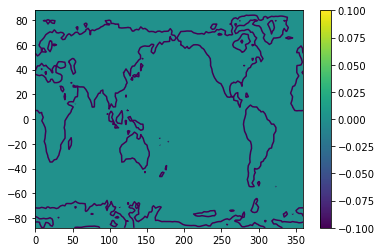

1


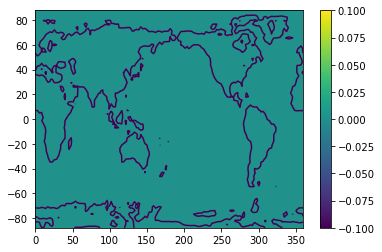

2


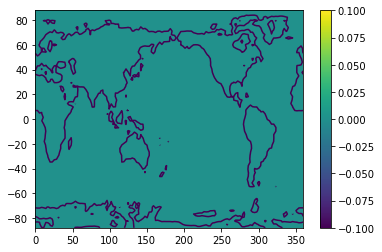

3


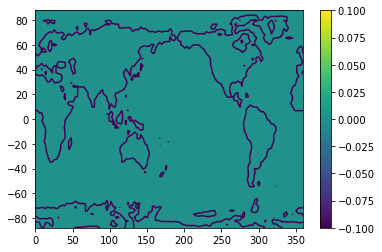

4


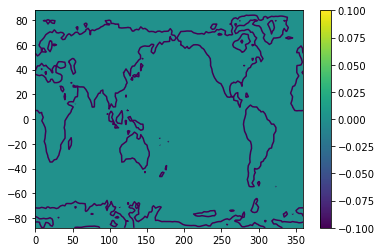

5


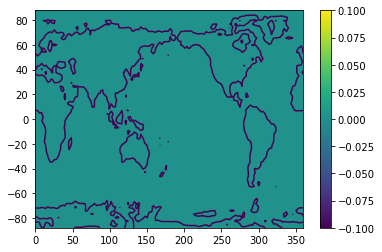

6


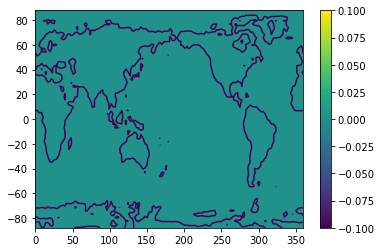

7


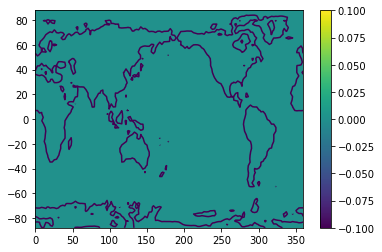

8


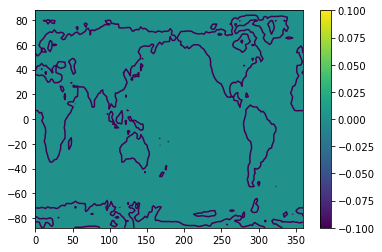

9


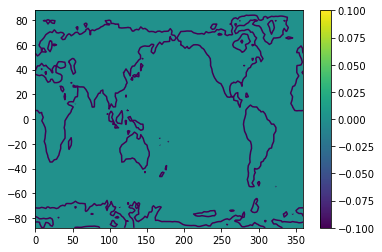

10


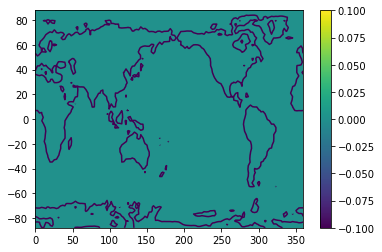

11


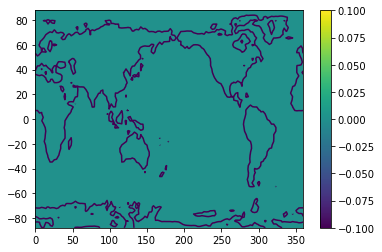

12


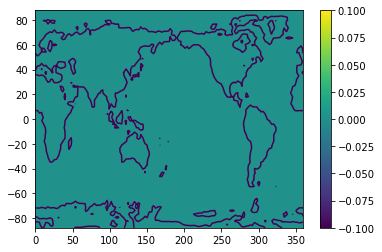

13


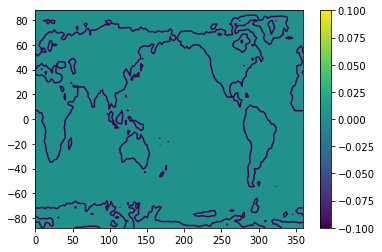

14


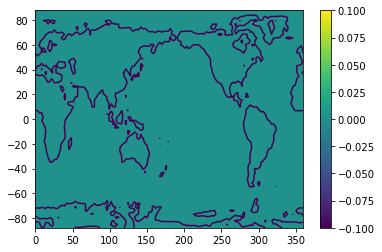

15


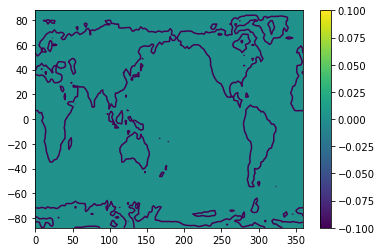

16


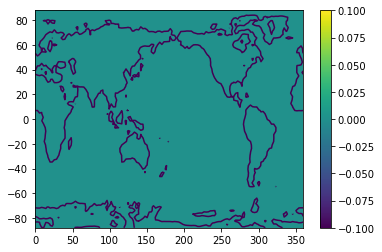

17


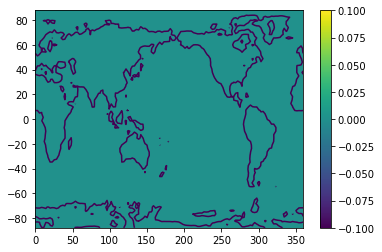

18


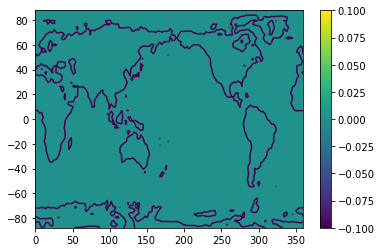

19


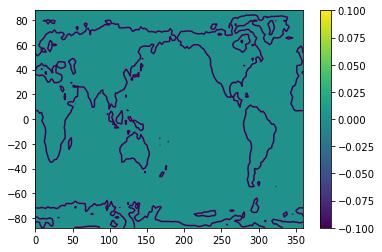

20


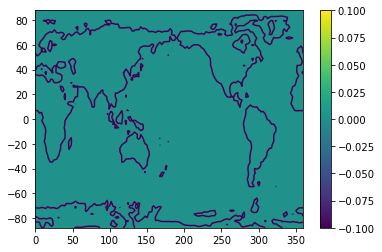

21


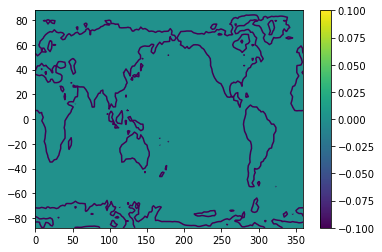

22


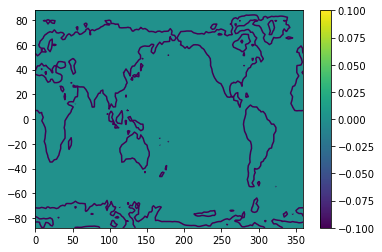

23


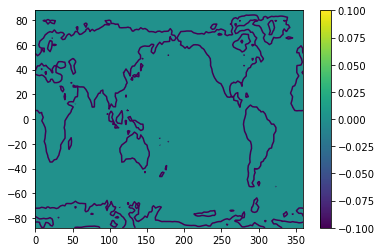

24


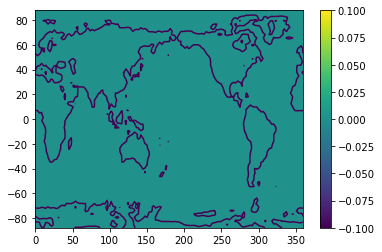

25


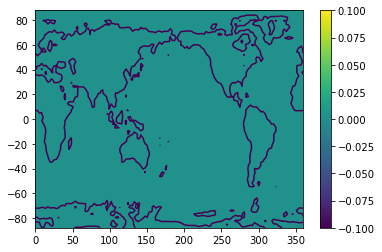

26


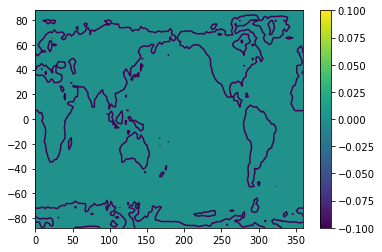

27


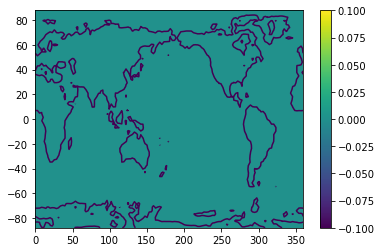

28


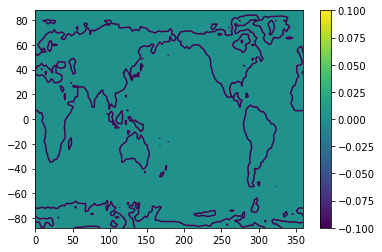

29


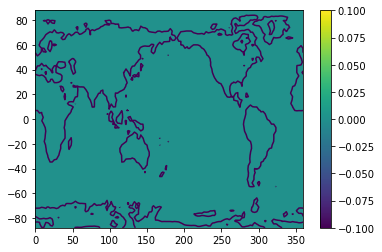

30


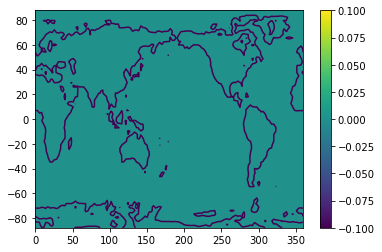

31


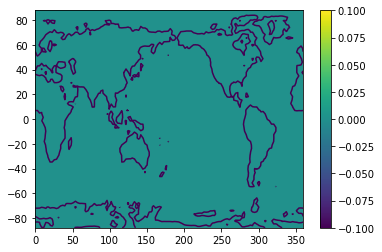

32


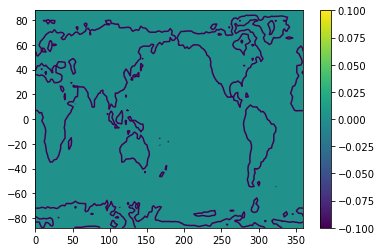

33


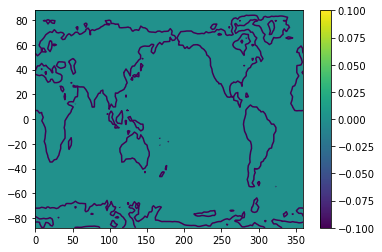

34


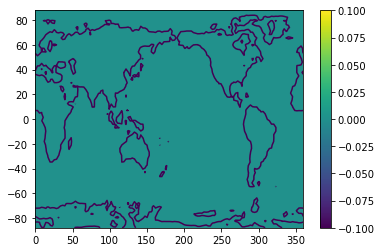

35


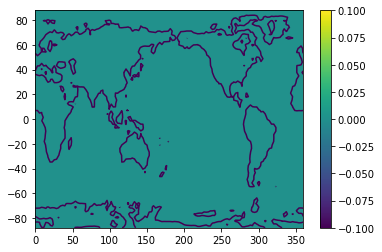

36


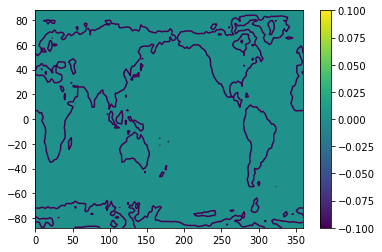

37


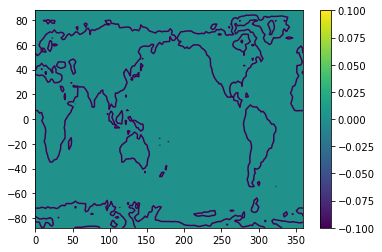

38


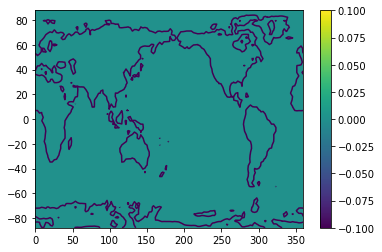

39


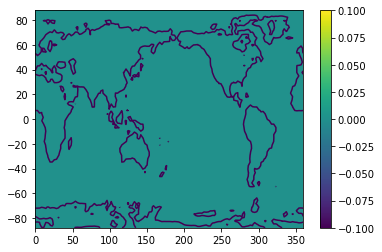

40


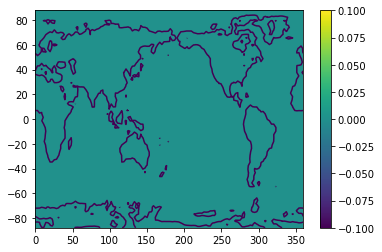

41


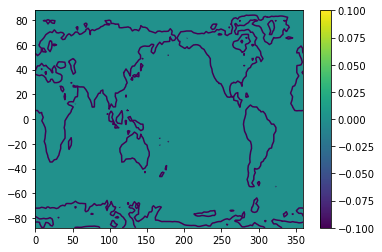

42


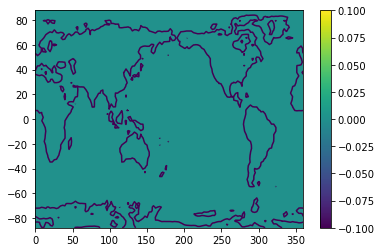

43


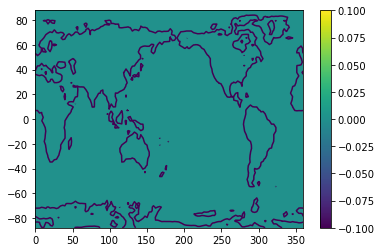

44


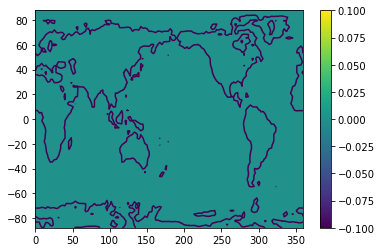

45


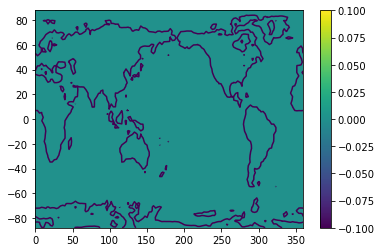

46


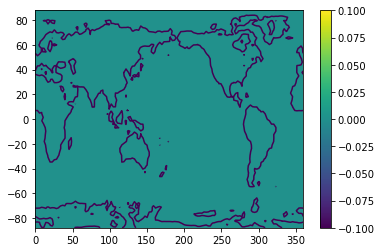

47


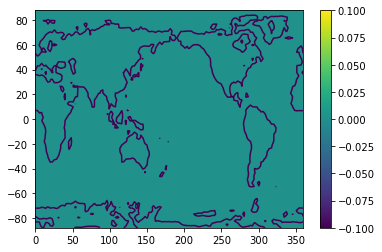

In [156]:
for i in range(len(grid.time_step)):
    print(i)
    #plt.pcolor(grid.elons,grid.lats,RSL[i,:,:],vmin=-250, vmax=900)
    plt.pcolor(grid.elons,grid.lats,RSL[t_it,:,:])
    plt.colorbar()
    plt.contour(grid.elons,grid.lats,topo.topo[i,:,:],[0])
    plt.show()

C:\Users\ahenry01\AppData\Local\ESRI\conda\envs\op\lib\site-packages\ipykernel_launcher.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


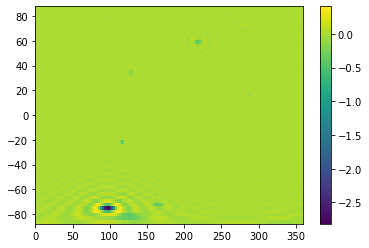

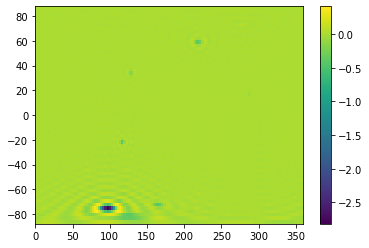

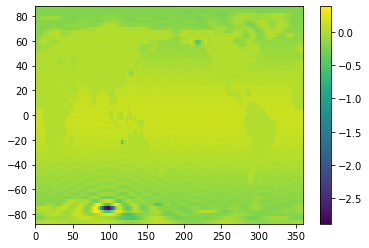

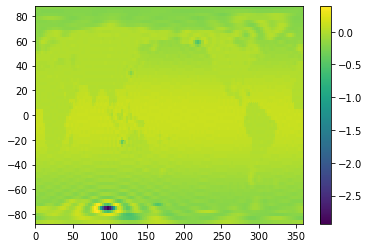

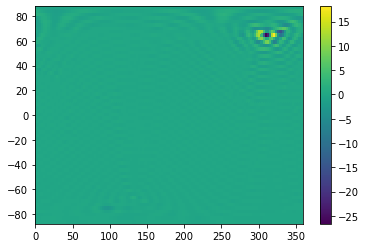

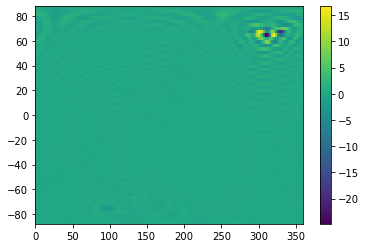

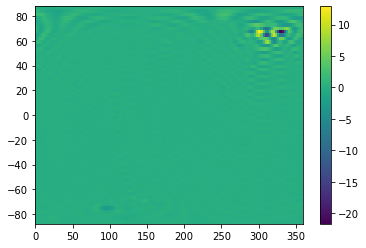

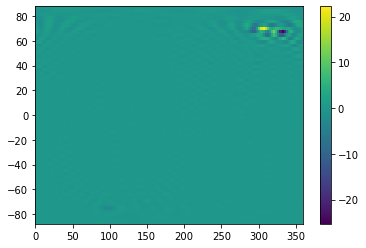

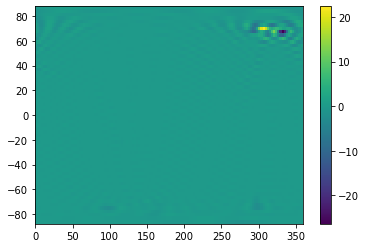

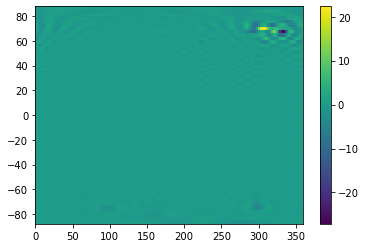

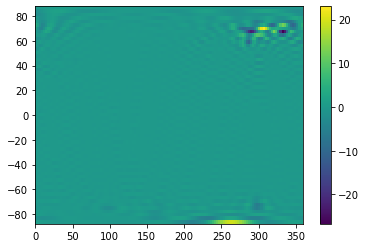

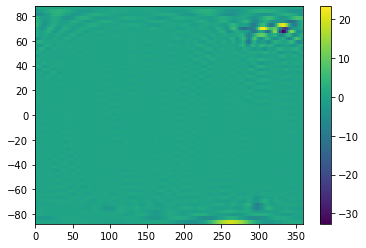

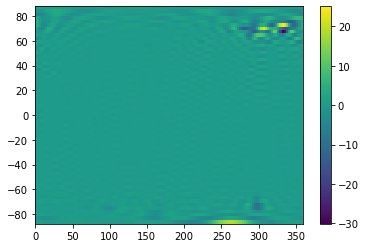

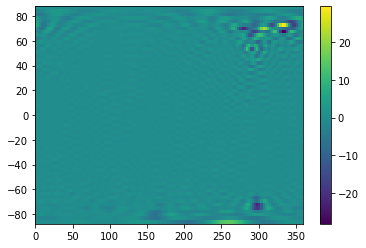

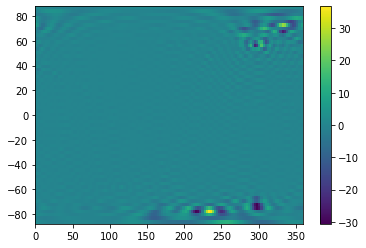

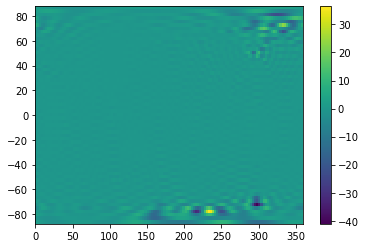

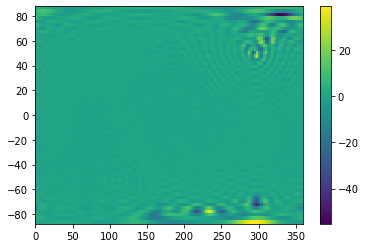

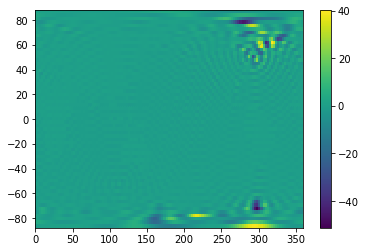

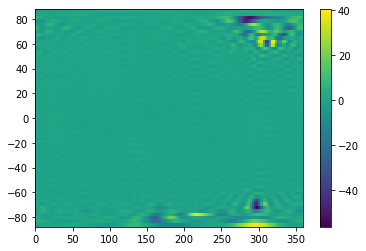

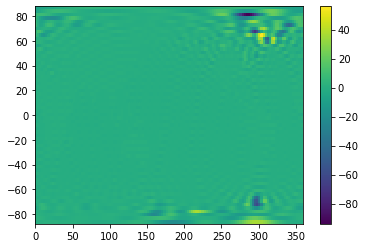

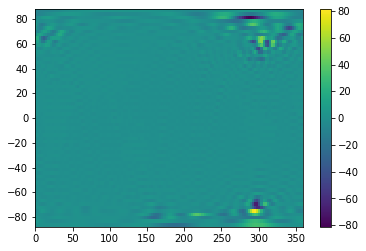

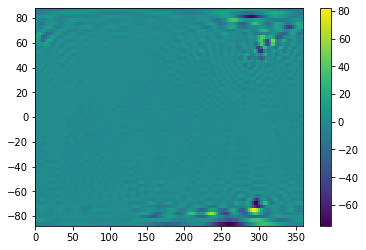

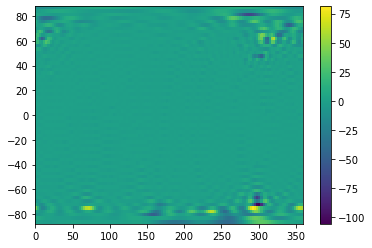

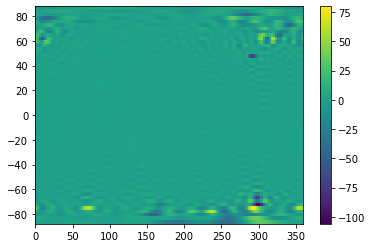

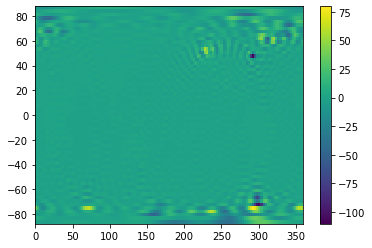

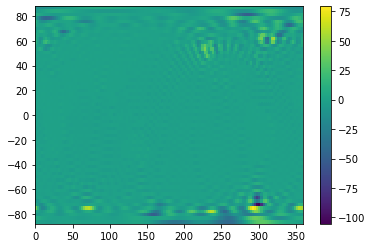

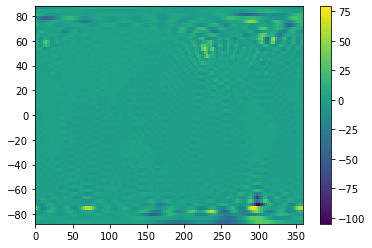

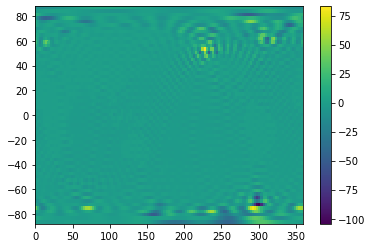

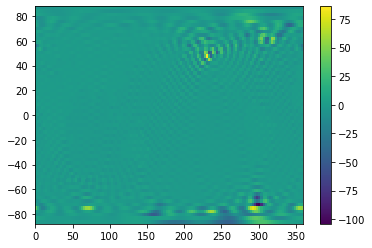

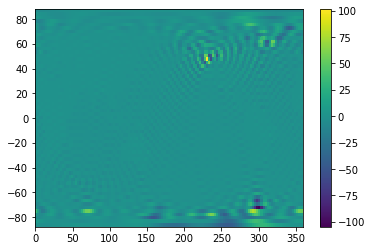

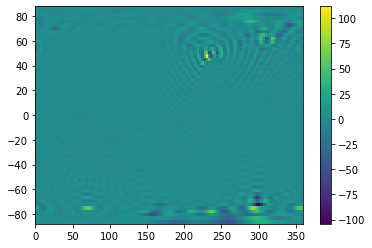

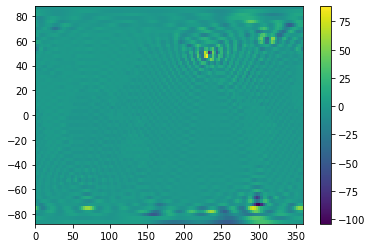

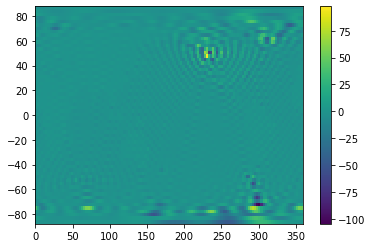

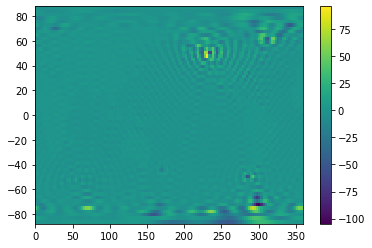

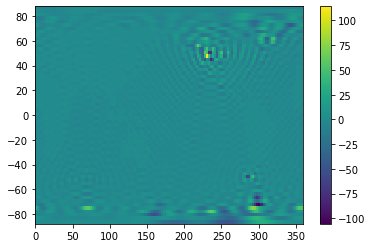

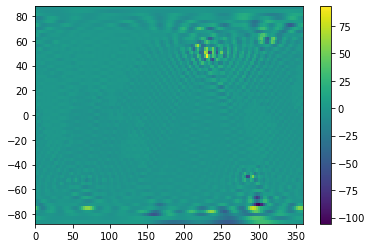

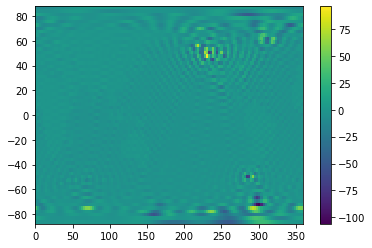

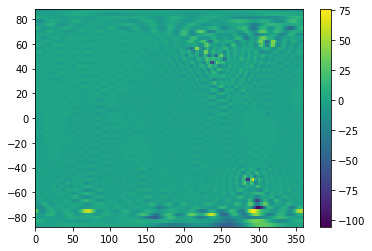

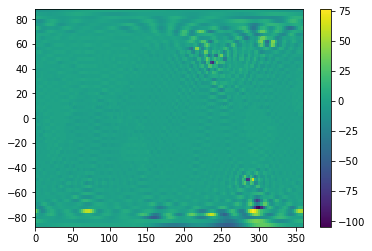

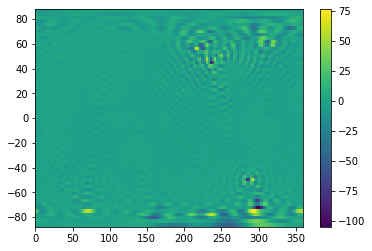

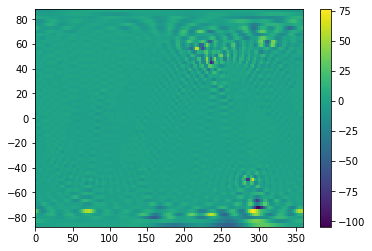

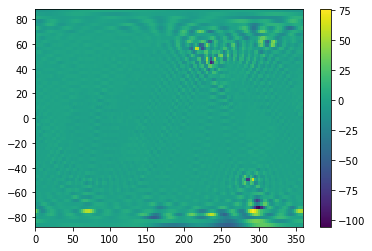

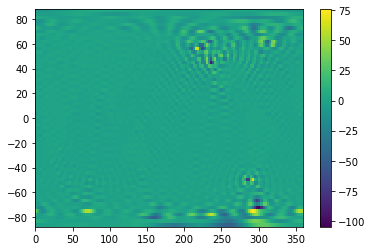

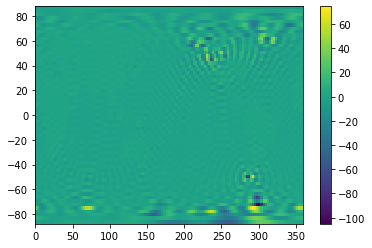

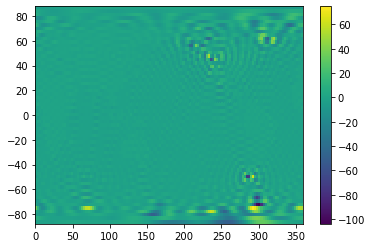

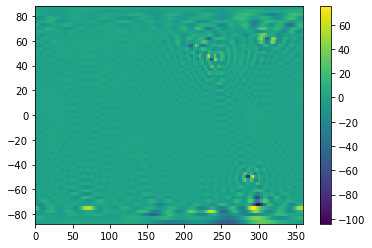

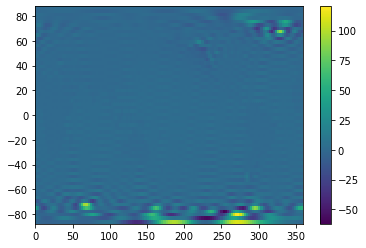

In [154]:
for i in range(len(grid.time_step)-1):
    plt.pcolor(grid.elons,grid.lats,to_grd(SL.saved[i,:,:]))
    plt.colorbar()
    plt.show()
    time.sleep(0.1)

### Convergence criterion

In [69]:
if chi < epsilon:
  print('Converged after iteration', k, 'Chi was', chi)
else:
  print ('Did not yet converge.')
  print ('Finished iteration', k, '; Chi was', chi)

end_time = time.time()

print ("Time elapsed in k loop", end_time - start_time)
# calculate the scaling to normalize the fingerprint (it's normalized to be
# one on average, when averaged over the final ocean basin). 
# calculate change in sea level over final ocean basin
del_scaling = (delSL + del_ice_corrected) * oc_j
# get the average of that when spreading the water over the whole globe
sca = sh.grdtospec(del_scaling, norm='unity')
# get the average of that when spreading the water only over the oceans.
scaling_fact = sca[0] / ocj_ml[0]

NameError: name 'chi' is not defined